In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import random
import math
import cmath as cm
from scipy.stats import unitary_group
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit, basinhopping
import matplotlib
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.autograd.functional import jacobian, hessian
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import torch_optimizer

import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

import torch

pi = np.pi

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    


set_random_seed(42)

In [3]:
torch.cuda.is_available()

True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [88]:
def atan2f(y, x, tolerance=torch.tensor(1e-6), to_degree=False):
    zero_y = torch.abs(y) <= tolerance
    zero_x = torch.abs(x) <= tolerance
    if zero_x and zero_y:
        rad = 0
    elif zero_x and (not zero_y):
        rad = torch.pi/2 if y > tolerance else -torch.pi/2
    elif (not zero_x) and zero_y:
        rad = 0 if x > tolerance else torch.pi
    else:
        rad = torch.arctan2(y, x)
    if to_degree:
        return torch.rad2deg(rad)
    else:
        return rad
    

def angle_diff(comp_src, comp_dst, offset=0, tolerance=torch.tensor(1e-6), wrap=True, to_degree=False):
    zero_src = torch.abs(comp_src) <= tolerance
    zero_dst = torch.abs(comp_dst) <= tolerance
    if zero_src and zero_dst:
        rad = 0
    elif zero_src and (not zero_dst):
        rad = torch.angle(comp_dst)
    elif (not zero_src) and zero_dst:
        rad = -torch.angle(comp_src)
    else:
        rad = torch.angle(comp_dst) - torch.angle(comp_src)
    rad += offset
    if wrap:
        rad = torch.remainder(rad, 2 * torch.pi)
    if to_degree:
        return torch.rad2deg(rad)
    else:
        return rad
    
def get_angles(N, v):
    return v[:N*(N-1)//2], v[N*(N-1)//2:2*N*(N-1)//2], v[2*N*(N-1)//2:2*N*(N-1)//2 + N]

In [103]:
def U2MZI(dim, m, n, phi, theta, Lp=torch.tensor(1), Lc=torch.tensor(1), device='cuda'):
    assert m < n < dim
    mat = torch.eye(dim, dtype=torch.complex128, device=device)
    mat[m, m] = torch.sqrt(Lp) * 1j * torch.exp(1j * phi) * torch.sin(theta)
    mat[m, n] = torch.sqrt(Lc) * 1j * torch.cos(theta)
    mat[n, m] = torch.sqrt(Lc) * 1j * torch.exp(1j * phi) * torch.cos(theta)
    mat[n, n] = -torch.sqrt(Lp) * 1j * torch.sin(theta)
    return mat

def decompose_reck(u, block='bs', device='cuda'):
    assert isinstance(u, torch.Tensor)
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if len(u.shape) != 2:
        raise ValueError("U(N) should be 2-dimension matrix.")
        
    if u.shape[0] != u.shape[1]:
        raise ValueError("U(N) should be a square matrix.")
        
    mat = u.clone().to(torch.complex128)
    dim = mat.shape[0]
    num = int(dim * (dim - 1) / 2)
    phis = torch.zeros(num, device=device)
    thetas = torch.zeros(num, device=device)
    alphas = torch.zeros(dim, device=device)
    index = 0
    for p in range(1, dim):
        x = dim - p
        for q in range(dim-p, 0, -1):
            y = q - 1
            if block == 'bs':
                thetas[index] = atan2f(torch.abs(mat[x,y]), torch.abs(mat[x,x]))
                phis[index] = angle_diff(mat[x,x], mat[x,y], offset=-np.pi/2)
                U2block = U2BS
            elif block == 'mzi':
                thetas[index] = np.pi/2 - atan2f(torch.abs(mat[x,y]), torch.abs(mat[x,x]))
                phis[index] = angle_diff(mat[x,x], mat[x,y], offset=np.pi)
                U2block = U2MZI
            mat = mat @ U2block(dim, y, x, phis[index], thetas[index]).conj().T
            index += 1
    for i in range(dim):
        alphas[i] = torch.angle(mat[i, i])
    return phis, thetas, alphas

def reconstruct_reck(phis, thetas, alphas, block='bs', Lp_dB=0, Lc_dB=0, device='cuda'):
    assert len(phis.squeeze().shape) == 1
    assert len(thetas.squeeze().shape) == 1
    assert len(alphas.squeeze().shape) == 1
    assert phis.squeeze().shape[0] == thetas.squeeze().shape[0]
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if block == 'bs':
        U2block = U2BS
    elif block == 'mzi':
        U2block = U2MZI
    
    num = thetas.squeeze().shape[0]
    dim = int((1 + np.sqrt(1 + 8 * num))/ 2)
    assert alphas.squeeze().shape[0] == dim
    
    Lp = torch.tensor(10 ** (Lp_dB / 10), device=device)
    Lc = torch.tensor(10 ** (Lc_dB / 10), device=device)
    
    mat = torch.diag(torch.exp(1j * alphas)).to(torch.complex128)
    index = num
    for p in range(1, dim):
        for q in range(p):
            index -= 1
            mat = mat @ U2block(dim, q, p, phis[index], thetas[index], Lp=Lp, Lc=Lc)
    return mat

In [6]:
def Haar_Random_U(n):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return q

def Haar_Random_U_torch(n, device):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return torch.from_numpy(q).to(dtype=torch.complex128, device=device)

def Is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

def Is_unitary_torch(m, device='cuda'):
    return torch.allclose(torch.eye(m.shape[0],dtype=torch.complex128, device=device), m.mH @ m)

In [145]:
N=4
U_true = Haar_Random_U_torch(N, device=device)
print("U_true:\n", U_true)
[p, t, a] = decompose_reck(U_true, block='mzi')
print(f'Reck[MZI] Decomposition:\n\tphis: {p}\n\tthetas: {t}\n\talphas: {a}')
reck_test = reconstruct_reck(p, t, a, block='mzi')
print(f'Reck[MZI] Reconstructed:\n{reck_test}')
print(f'Reck[MZI] Test:\t\t {torch.allclose(reck_test, U_true)}')

U_true:
 tensor([[-0.0547+0.4625j, -0.3817-0.1414j,  0.5737+0.2595j,  0.4684-0.0386j],
        [ 0.3021-0.3937j, -0.5182-0.4697j, -0.3583+0.0658j,  0.2399-0.2728j],
        [ 0.0241-0.0102j,  0.5356+0.1203j, -0.1132+0.4077j,  0.3463-0.6317j],
        [ 0.6731+0.2882j, -0.0767+0.1948j, -0.1450+0.5204j, -0.3049+0.1877j]],
       device='cuda:0', dtype=torch.complex128)
Reck[MZI] Decomposition:
	phis: tensor([2.3944, 0.9271, 4.0980, 3.3745, 4.2836, 0.4911], device='cuda:0')
	thetas: tensor([0.5853, 1.2582, 0.7492, 0.9485, 1.5324, 0.7537], device='cuda:0')
	alphas: tensor([ 0.6698, -1.9350,  0.6442,  1.0189], device='cuda:0')
Reck[MZI] Reconstructed:
tensor([[-0.0547+0.4625j, -0.3817-0.1414j,  0.5737+0.2595j,  0.4684-0.0386j],
        [ 0.3021-0.3937j, -0.5182-0.4697j, -0.3583+0.0658j,  0.2399-0.2728j],
        [ 0.0241-0.0102j,  0.5356+0.1203j, -0.1132+0.4077j,  0.3463-0.6317j],
        [ 0.6731+0.2882j, -0.0767+0.1948j, -0.1450+0.5204j, -0.3049+0.1877j]],
       device='cuda:0', dtype=to

In [127]:
data = []
data_no_current = []
for ch in range(4):
    for H in range(3):
        with open(f"Calibration Example_915\ch{ch + 1}_H{H + 1}.txt") as file:
            for line in file:
                try:
                    row = [float(num) for num in line.split()]
                    if row[0] % 40 == 0:
                        data.append([ch,H] + row)
                    else:
                        continue
                    if row[0] == 0:
                        data_no_current.append([ch,H] + row)
                except:
                    pass

def f(v, data=data, device='cuda'):
    p1, t1, a1 = get_angles(4, v[:16])
    p2, t2, a2 = get_angles(4, v[16:32])
    M1 = reconstruct_reck(p1, t1, a1, block='mzi')
    M2 = reconstruct_reck(p2, t2, a2, block='mzi')
    alpha = v[32:41].reshape(3, 3)
    h_0 = v[41:44]
    current_coefficient = np.sqrt(0.5*10**(-5))
    cost = 0

    for i in data:
        x = torch.zeros(3, dtype=torch.float32, device=device)
        x[i[1]] = current_coefficient * i[2] ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)
        
        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def clement_reconstruction(v, U):
    p, t, a = get_angles(4, v)
    reck = reconstruct_reck(p, t, a, block='mzi')
    return np.linalg.norm(reck - U)

In [ ]:
def f_hessian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

[ 0.00000000e+00 -9.76996262e-15  1.11022302e-15  4.03234775e+00
 -1.91685642e+00  1.14812344e+00  1.50630145e+00 -1.25082838e+02
 -2.10952912e-01  3.35424174e+01  2.17780079e+00  2.55052898e+01
  3.13544023e-02 -2.68690909e-01  5.47663305e-01 -3.10326798e-01
  5.47663305e-01 -2.68690909e-01  3.13544023e-02 -1.42072865e+00
  4.63937005e+00  1.40178627e+00 -4.92057362e+00  2.60470569e+01
 -6.64919204e+00  1.86251372e+01  3.29614922e+01 -2.90375712e+00
 -1.33211573e-14  6.39393325e-15 -4.86443484e-15  2.00566471e-15
 -2.51293436e+02  6.82907916e+02 -1.14355755e+02 -1.30071743e+03
  6.12328439e+02 -1.95315936e+03  1.98964046e+03  1.45789031e+03
  3.98478389e+03  3.13544023e-02 -2.68690909e-01  5.47663305e-01]


In [147]:
U_true = Haar_Random_U_torch(N, device=device)
x0 = torch.rand(32, dtype=torch.float64, device=device)
minimize(clement_reconstruction, x0, args=(U_true,))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [62]:
reck_test = reconstruct_reck(*get_angles(N, result.x), block='mzi')
print(f'Reck[MZI] Test:\t\t {np.allclose(reck_test, U_true)}')

Reck[MZI] Test:		 False


In [ ]:
min_loss = 1e10
steps = 9

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

def closure():
    optimizer.zero_grad()
    loss = toy_torch_no_data_Clements(D_initial)
    loss.backward(create_graph=True)
    # torch.nn.utils.clip_grad_norm_(x0, max_norm=1.0)
    print(f"loss: {loss.item()}")
    if loss.item() < 1e-5:
        print("Converged")
    return loss

for n in range(steps):
    print(f"Step {n + 1}/{steps}")
    optimizer.step(closure)
    # scheduler.step()
    print(D_initial.grad)
        
    if n == steps - 1:
        print("Final loss:", closure().item())
        print("Final parameters:", D_initial.data.cpu().numpy())
        if loss.item() < min_loss:
            min_loss = loss.item()
            D_optimized = D_initial.clone()
            print("Updated optimized parameters")
        # x0 = nn.Parameter(torch.randn(36, dtype=torch.float32, device=device), requires_grad=True)

In [141]:
seed = 43
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

x0 = nn.Parameter(torch.randn(44, dtype=torch.float32, device=device), requires_grad=True)
optimizer =  torch.optim.LBFGS([x0], lr=0.1)#optim.Adam([x0])
# with torch.no_grad():
#      x0[36].fill_(1e-2)
# optimizer = torch_optimizer.Adahessian([x0])
# U = create_un_mat(x0, device=device)
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)
print(x0)

Parameter containing:
tensor([ 1.9983,  1.9810,  1.4458,  1.9813,  1.1984,  1.5074,  1.2356, -2.1881,
        -0.1357,  0.6757, -2.4663, -0.3968,  0.3081,  0.0580,  0.2376,  0.2529,
         1.6512, -1.3475, -0.9442, -0.3984, -0.2502,  0.6572, -1.4027,  0.5761,
        -1.2621, -1.0164,  0.5897,  1.1275, -0.9890, -1.9060,  0.9742,  0.6774,
        -0.6134,  1.0924,  0.0282,  0.6257, -0.5986, -1.4145, -1.6238, -2.3902,
        -0.2232, -0.6067, -1.3207, -0.8876], device='cuda:0',
       requires_grad=True)


In [ ]:
from torch.utils.tensorboard import SummaryWriter


min_loss = 1e10
steps = 50

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

def closure():
    optimizer.zero_grad()
    loss = f(x0)
    loss.backward(create_graph=True)
    # torch.nn.utils.clip_grad_norm_(x0, max_norm=1.0)
    print(f"loss: {loss.item()}")
    if loss.item() < 1e-5:
        print("Converged")
    return loss

run_id = datetime.now().strftime("test")
log_dir = os.path.join("logs", "ex1", run_id)
writer = SummaryWriter(log_dir='logs/ex1')

for n in range(steps):
    print(f"Step {n + 1}/{steps}")
    optimizer.step(closure)
    # scheduler.step()
    print(x0.grad)

    # with torch.no_grad():
    #     loss = f_torch_no_data_Reck(x0, data)
    #     writer.add_scalar("Loss/train", loss.item(), n)
    #     writer.add_scalar("Learning rate", scheduler.get_last_lr()[0], n)
        
    # if n == steps - 1:
    #     print("Final loss:", closure().item())
    #     print("Final parameters:", x0.data.cpu().numpy())
    #     if loss.item() < min_loss:
    #         min_loss = loss.item()
    #         x0_optimized = x0.clone()
            # print("Updated optimized parameters")
        # x0 = nn.Parameter(torch.randn(36, dtype=torch.float32, device=device), requires_grad=True)

# writer.close()

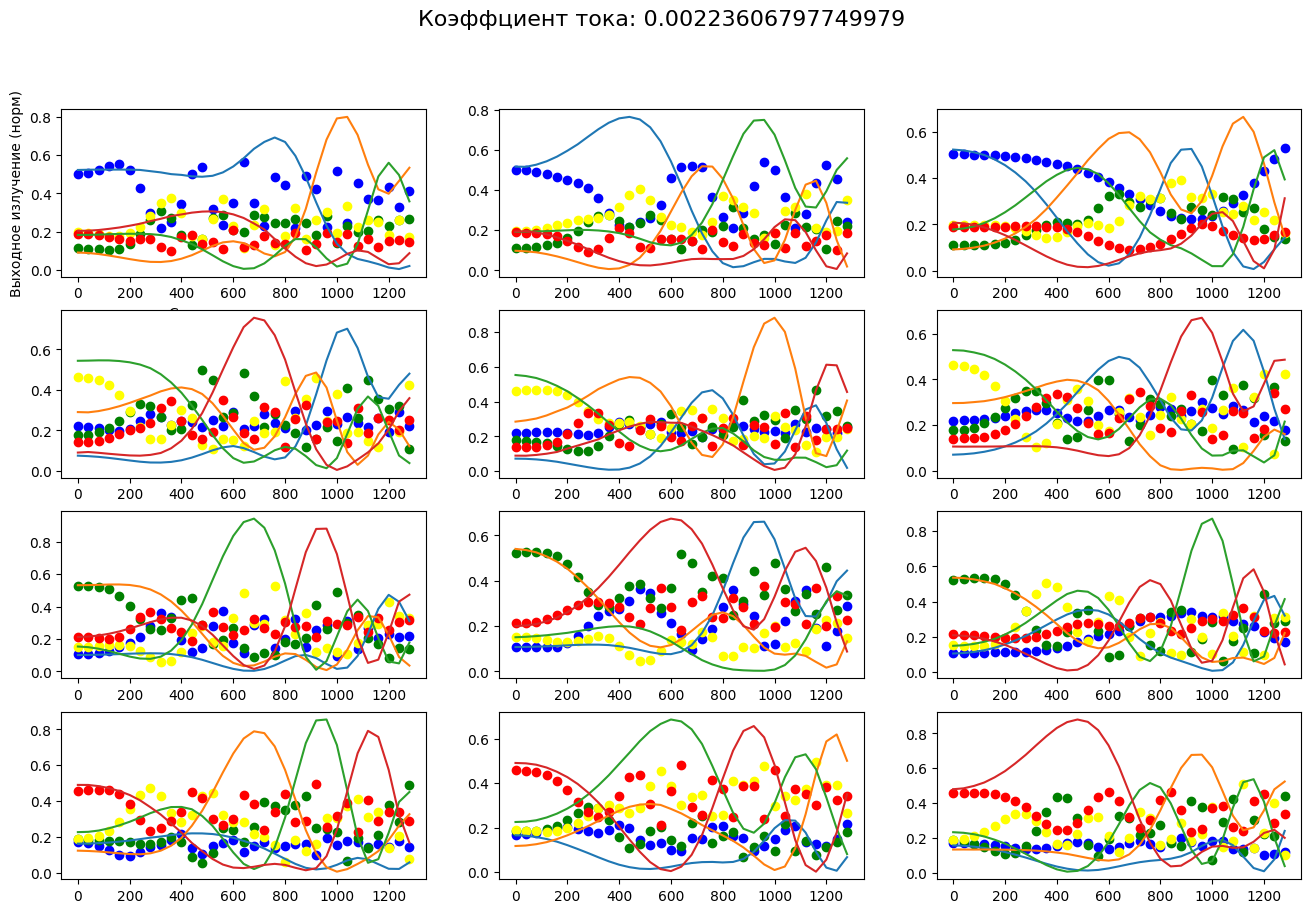

In [73]:
# x0 = result_basinhop.x
x0 = result.x
# x0 = torch.from_numpy(result.x).to(device=device)
# x0 = torch.randn(42, dtype=torch.float32, device=device)*100

# M1 = create_un_mat_torch(x0[:12], device=device)
# M2 = create_un_mat_torch(x0[12:24], device=device)
# M1 =  Reck_extand_torch(4, x0[:12], device=device)
# M2 =  Reck_extand_torch(4, x0[12:24], device=device)
# alpha = torch.tensor(x0[24:33], dtype=torch.complex128, device=device).reshape(3, 3)
# h_0 = torch.tensor(x0[33:36], dtype=torch.complex128, device=device)
M1 =  reconstruct_reck(*get_angles(4, x0[:16]), block='mzi')
M2 =  reconstruct_reck(*get_angles(4, x0[16:32]), block='mzi')
alpha = np.reshape(x0[32:41], (3, 3))
h_0 = x0[41:44]

current_coefficient = np.sqrt(0.5*10**(-5))

fig, ax = plt.subplots(4, 3, figsize=(16, 10))

for j in range(4):
    for k in range(3):

        # for i in data[131*(3*j+k):131*(3*j+k+1)]:
        for i in data[33*(3*j+k):33*(3*j+k+1)]:
            # x = torch.zeros(3, dtype=torch.complex128, device=device)
            # x[i[1]] = (current_coefficient * i[2]) ** 2
            # y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
            # y /= torch.sum(y)

            # h_list = h_0 + alpha @ x
            # H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            # H = torch.diag(H_diag)
            # result_plot = (torch.abs((M2 @ H @ M1).T) ** 2)[i[0]]
            # ax[j][k].scatter(i[2], result_plot[0].cpu().detach().numpy(), color = 'blue')
            # ax[j][k].scatter(i[2], result_plot[1].cpu().detach().numpy(), color = 'green')
            # ax[j][k].scatter(i[2], result_plot[2].cpu().detach().numpy(), color = 'yellow')
            # ax[j][k].scatter(i[2], result_plot[3].cpu().detach().numpy(), color = 'red')

            x = np.zeros(3)
            x[i[1]] = (current_coefficient * i[2]) ** 2
            y = i[3:]
            y /= np.sum(y)

            h_list = h_0 + alpha.dot(np.transpose(x))
            # H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
            result_plot = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
            ax[j][k].scatter(i[2], result_plot[0], color = 'blue')
            ax[j][k].scatter(i[2], result_plot[1], color = 'green')
            ax[j][k].scatter(i[2], result_plot[2], color = 'yellow')
            ax[j][k].scatter(i[2], result_plot[3], color = 'red')

        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[3]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'blue')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[4]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'green')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[5]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'yellow')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[6]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'red')

        ax[0][0].set_xlabel('Сила тока, единицы')
        ax[0][0].set_ylabel('Выходное излучение (норм)')

        fig.suptitle('Фитирование данных Ильи с помощью нашего кода')
        fig.suptitle('Коэффциент тока: ' + str(current_coefficient), fontsize=16)


plt.show()